In [1]:
! pip install pandas scikit-learn seaborn matplotlib torch

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [7]:

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np


def setup_data(data):
    # Replace anything that matches the regex with a white space
    expressions_to_replace_whitespace = [r'^.+-[a-zA-Z]{2}-\d+$', r'^[a-zA-Z]{2}-\d+-\d+$', r'\s-\s', r'x{3,}']
    expressions_to_remove = [r'["\']', r'[nN]°?\d+', r'[nN]\d+', r'[nN]º?\d+']
    for expr in expressions_to_replace_whitespace:
        data['Document'] = data['Document'].str.replace(expr, ' ', regex=True)
    for expr in expressions_to_remove:
        data['Document'] = data['Document'].str.replace(expr, '', regex=True)
    return data

train_data = pd.read_csv('train.csv')
train_data = setup_data(train_data)
test_data = pd.read_csv('test.csv')
test_data = setup_data(test_data)
df = pd.DataFrame(train_data)

device = 'cuda' if torch.cuda.is_available() else 'cpu'



FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [ ]:



X = df["Document"]
y = df["Segment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.35,test_size=0.10, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

classifier = SVC(kernel='linear')
classifier.fit(X_train_tfidf, y_train)

y_pred = classifier.predict(X_test_tfidf)
report = classification_report(y_test, y_pred)
print(report)


                  precision    recall  f1-score   support

         CIMENTO       1.00      0.75      0.86         8
      Construção       1.00      0.99      1.00       177
         ENERGIA       1.00      0.87      0.93        15
 INFRA ESTRUTURA       1.00      1.00      1.00       469
      METALURGIA       0.98      0.89      0.93        46
       MINERAÇÃO       0.99      1.00      0.99      4977
      OLEO E GAS       1.00      0.83      0.91        54
PAPEL E CELULOSE       0.99      0.97      0.98      3475
         QUIMICA       1.00      0.92      0.96        77
      SIDERURGIA       0.99      1.00      0.99     10877

        accuracy                           0.99     20175
       macro avg       1.00      0.92      0.96     20175
    weighted avg       0.99      0.99      0.99     20175



## Results And Test Cases

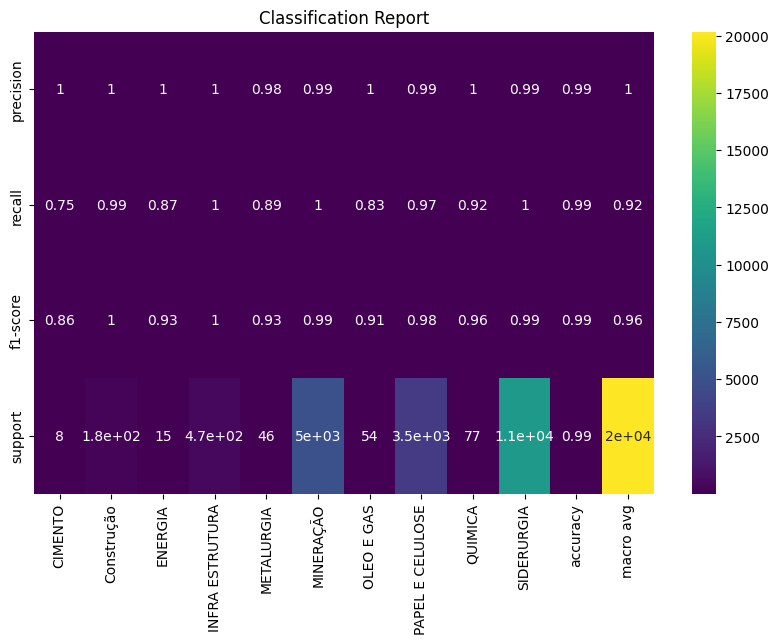

In [4]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :].T, annot=True, cmap='viridis')
plt.title('Classification Report')
plt.show()

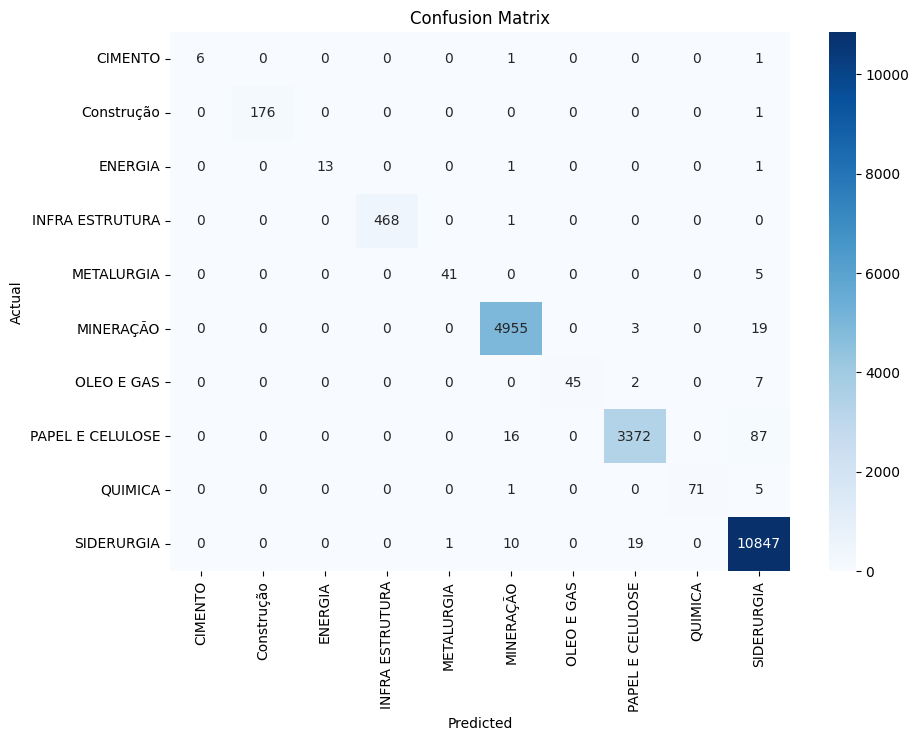

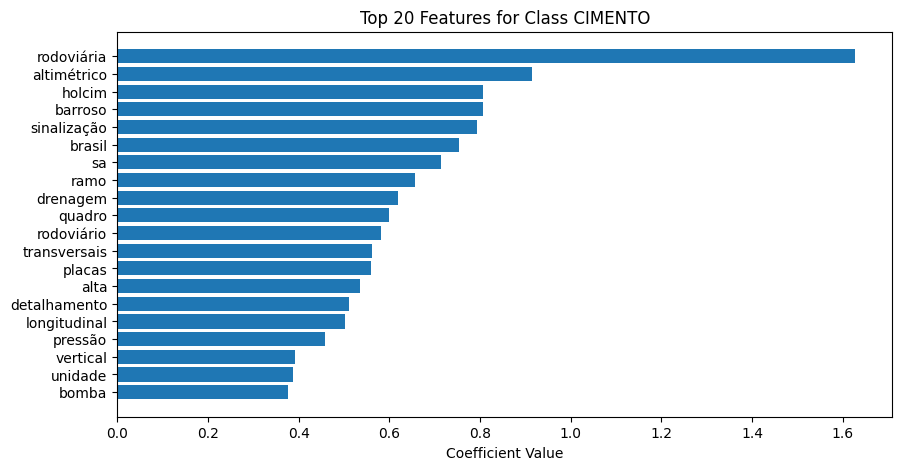

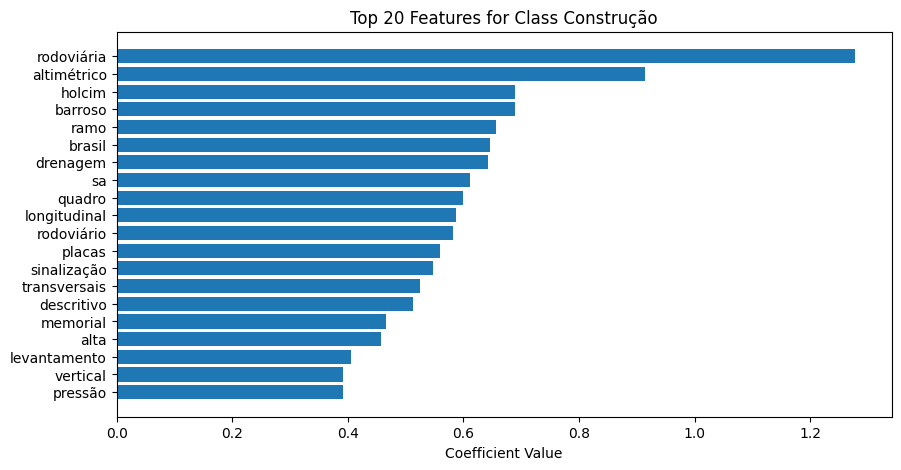

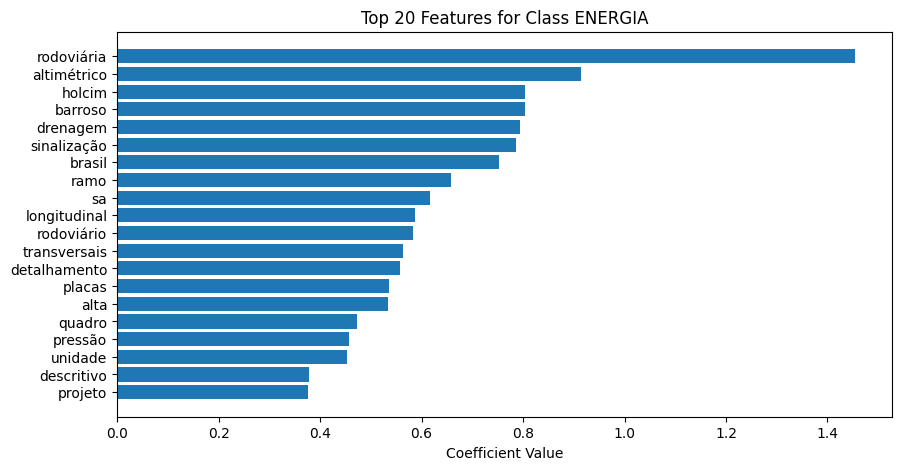

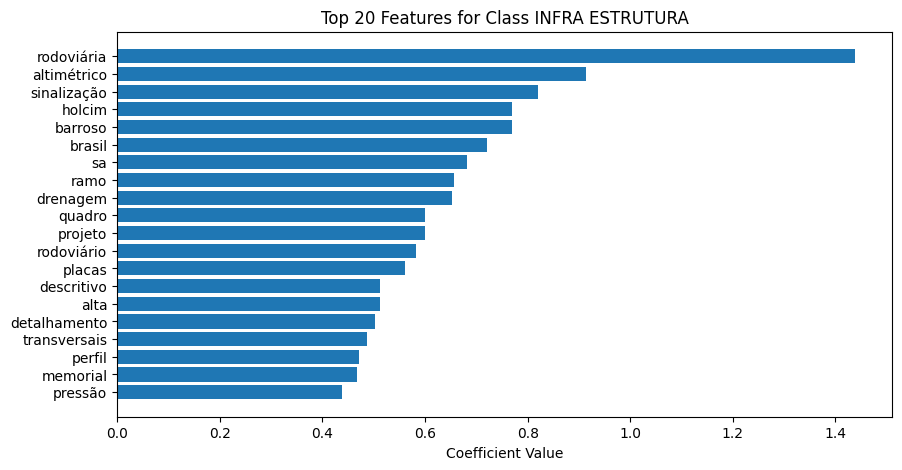

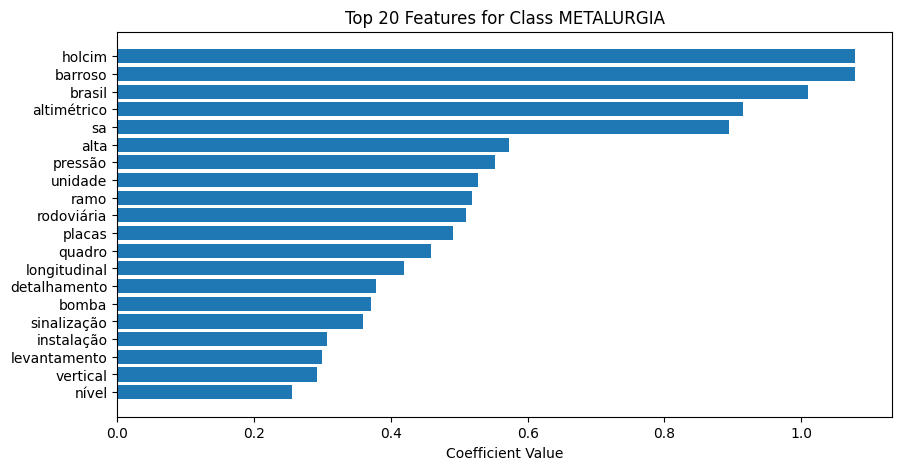

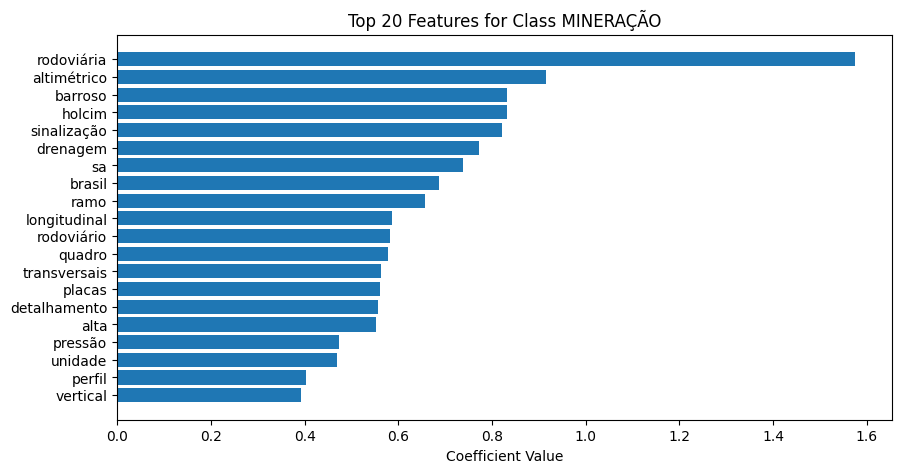

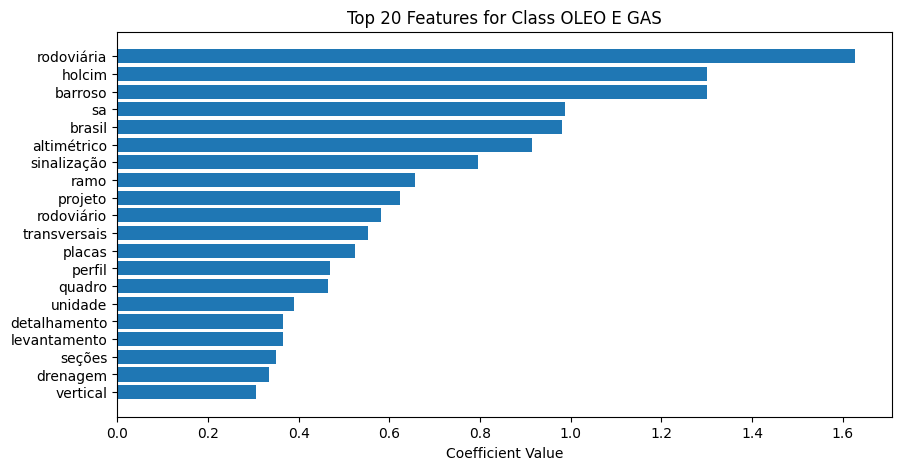

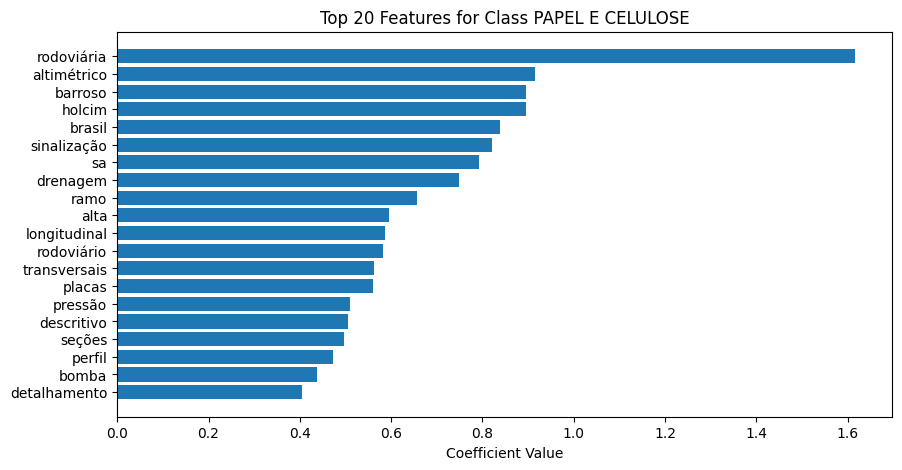

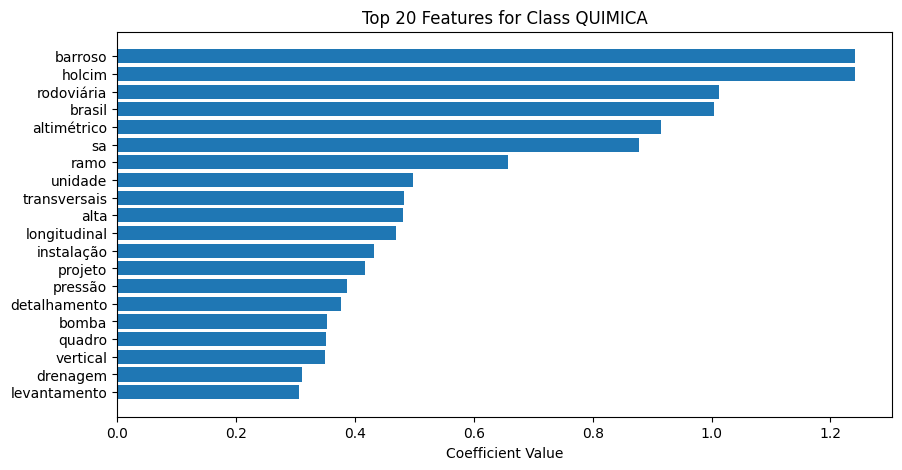

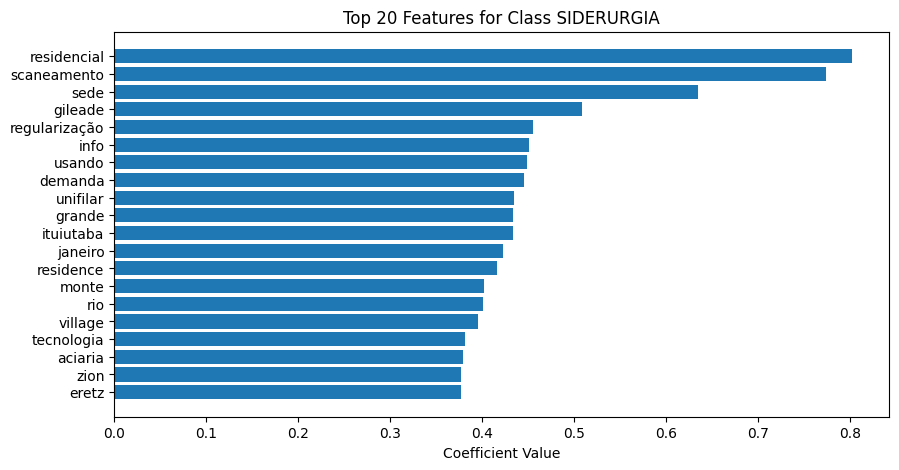

In [5]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Get feature importance for linear SVM
feature_names = vectorizer.get_feature_names_out()
coefficients = classifier.coef_.toarray()

# Plot top 20 features for each class
for i, class_label in enumerate(classifier.classes_):
    top20_indices = np.argsort(coefficients[i])[-20:]
    top20_features = feature_names[top20_indices]
    top20_coefficients = coefficients[i][top20_indices]
    
    plt.figure(figsize=(10, 5))
    plt.barh(top20_features, top20_coefficients)
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 20 Features for Segment: {class_label}')
    plt.show()

In [6]:

# Test some cases
sample_texts = [
    "BENEFICIAMENTO DE MINERIO DE FERRO - MINA IPÊ - PROJETO DE MELHORIA DA REDE PLUVIAL E PAVIMENTAÇÃO - TERRAPLENAGEM - SEÇÕES TRANSVERSAIS",
    "U700 - GERAL /PRÉDIOS - ED55A2 -  PRÉDIO NITRATO CONCENTRADO (UCAN I) 98% - ADEQUAÇÃO DO SISTEMA DE ILUMINAÇÃO DE EMERGÊNCIA",
    "UNIDADE CUB 1ADEQUAÇÃO AMBIENTAL DO CANAL DE EFLUENTES CQ 5 ADEQUAÇÃO DA TUBULAÇÃO DAS NOVAS BOMBAS P5713 A-B ISOMÉTRICO  -TRECHO 3"
]
test_data = r

sample_texts_tfidf = vectorizer.transform(sample_texts)
sample_predictions = classifier.predict(sample_texts_tfidf)

for text, prediction in zip(sample_texts, sample_predictions):
    print(f"Text: {text}\nPredicted Segment: {prediction}\n")

Text: BENEFICIAMENTO DE MINERIO DE FERRO - MINA IPÊ - PROJETO DE MELHORIA DA REDE PLUVIAL E PAVIMENTAÇÃO - TERRAPLENAGEM - SEÇÕES TRANSVERSAIS
Predicted Segment: MINERAÇÃO

Text: U700 - GERAL /PRÉDIOS - ED55A2 -  PRÉDIO NITRATO CONCENTRADO (UCAN I) 98% - ADEQUAÇÃO DO SISTEMA DE ILUMINAÇÃO DE EMERGÊNCIA
Predicted Segment: QUIMICA

Text: UNIDADE CUB 1ADEQUAÇÃO AMBIENTAL DO CANAL DE EFLUENTES CQ 5 ADEQUAÇÃO DA TUBULAÇÃO DAS NOVAS BOMBAS P5713 A-B ISOMÉTRICO  -TRECHO 3
Predicted Segment: QUIMICA

